# Sanity Check Graph

In [3]:
import numpy as np
import torch
import os

In [21]:
dir = "./data/era5_uk/static/nwp_xy.npy"
grid_xy = torch.tensor(np.load(dir))
_, lon, lat = grid_xy.shape

graph_name = "uk_graphcast"
graph_dir_path = os.path.join("graphs", graph_name)

### Verify M2M Graph

In [32]:
mesh_features = torch.load(os.path.join(graph_dir_path, "mesh_features.pt"))
m2m_features = torch.load(os.path.join(graph_dir_path, "m2m_features.pt"))
m2m_edge_index = torch.load(os.path.join(graph_dir_path, "m2m_edge_index.pt"))

print(mesh_features[0].shape)
print(m2m_features[0].shape)
print(m2m_edge_index[0].shape)
print(m2m_edge_index[0].unique().shape)

torch.Size([149, 3])
torch.Size([1008, 4])
torch.Size([2, 1008])
torch.Size([149])


### Verify G2M Graph

In [39]:
g2m_features = torch.load(os.path.join(graph_dir_path, "g2m_features.pt"))
g2m_edge_index = torch.load(os.path.join(graph_dir_path, "g2m_edge_index.pt"))

print(g2m_features.shape)
print(g2m_edge_index.shape)
print(g2m_edge_index[0].unique().shape)
print(g2m_edge_index[1].unique().shape)
print(lat * lon)

torch.Size([5321, 4])
torch.Size([2, 5321])
torch.Size([3705])
torch.Size([149])
3705


### Verify M2G Graph

In [40]:
m2g_features = torch.load(os.path.join(graph_dir_path, "m2g_features.pt"))
m2g_edge_index = torch.load(os.path.join(graph_dir_path, "m2g_edge_index.pt"))

print(m2g_features.shape)
print(m2g_edge_index.shape)
print(m2g_edge_index[0].unique().shape)
print(m2g_edge_index[1].unique().shape)
print(lat * lon)

torch.Size([11033, 4])
torch.Size([2, 11033])
torch.Size([149])
torch.Size([3705])
3705


# Parameter weighting

In [11]:
import numpy as np
import matplotlib.pyplot as plt

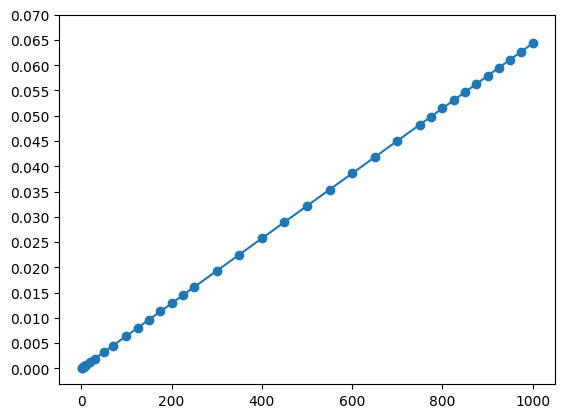

In [20]:
pressure_levels = np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000])
# x_axis = np.linspace(0, )

weighting = pressure_levels / sum(pressure_levels)
fig, ax = plt.subplots()

ax.plot(pressure_levels, weighting, marker='o')
y_ticks = np.arange(0, 0.07, 0.005)
ax.set_yticks(y_ticks)

In [24]:
subset_levels = [int(i) for i in ['50', '150', '250', '400', '500', '600', '850', '1000']]
subset_weighting = np.array([weighting[pressure_levels == i][0] for i in subset_levels])
subset_weighting

array([0.00321585, 0.00964754, 0.01607924, 0.02572678, 0.03215848,
       0.03859017, 0.05466941, 0.06431695])

# Download Progress

In [4]:
a = """2022_02.nc  2022_04.nc  2022_06.nc  2022_08.nc  2022_10.nc  2022_12.nc  2023_03.nc  2023_05.nc  2023_07.nc
2022_03.nc  2022_05.nc  2022_07.nc  2022_09.nc  2022_11.nc  2023_02.nc  2023_04.nc  2023_06.nc  2023_08.nc
"""

b = a.split()
b.sort()

In [5]:
b

['2022_02.nc',
 '2022_03.nc',
 '2022_04.nc',
 '2022_05.nc',
 '2022_06.nc',
 '2022_07.nc',
 '2022_08.nc',
 '2022_09.nc',
 '2022_10.nc',
 '2022_11.nc',
 '2022_12.nc',
 '2023_02.nc',
 '2023_03.nc',
 '2023_04.nc',
 '2023_05.nc',
 '2023_06.nc',
 '2023_07.nc',
 '2023_08.nc']

# PyTorch and NumPy

In [ ]:
import torch

In [14]:
batch_size = 4
N_grid = 250
d_features = 42

prev_prev_state = torch.rand((batch_size, N_grid, d_features))
prev_state = torch.rand((batch_size, N_grid, d_features))
# sample_len = 5
target_states = [torch.rand((N_grid, d_features)), torch.rand((N_grid, d_features)), torch.rand((N_grid, d_features))]
target_states = torch.stack(target_states, dim=0)
target_states = target_states.unsqueeze(0).repeat(batch_size, 1, 1, 1)

forcings = torch.zeros(batch_size, target_states.shape[1], target_states.shape[2], 0) # (batch_size, sample_len-2, N_grid, d_forcing)
forcing = forcings[:, 2]

In [15]:
print(prev_prev_state.shape)
print(prev_state.shape)
print(target_states.shape)
print(forcings.shape)
print(forcing.shape)

torch.Size([4, 250, 42])
torch.Size([4, 250, 42])
torch.Size([4, 3, 250, 42])
torch.Size([4, 3, 250, 0])
torch.Size([4, 250, 0])


In [16]:
grid_features = torch.cat(
    (
        prev_prev_state,
        prev_state,
        forcing
    ),
    dim=-1
)

In [17]:
grid_features.shape

torch.Size([4, 250, 84])

tensor([], size=(3, 0))

# ERA5 Dataset

In [1]:
import xarray as xr
import zarr
import numcodecs
import numpy as np
import glob
import torch
import era5_data_proc

RAW_ERA5_PATH = "/vol/bitbucket/bet20/dataset/era5"


In [2]:
nc_files = glob.glob(f'{RAW_ERA5_PATH}/global/*.nc')
nc_files[0]

'/vol/bitbucket/bet20/dataset/era5/global/2022_01.nc'

In [3]:
data = xr.open_dataset(nc_files[0])
data = era5_data_proc.uk_subset(data)

In [4]:
array = data.to_array().values[0]
array = array.transpose(3, 2, 0, 1)
print(array.shape)
N_lon, N_lat = array.shape[0], array.shape[1]
array = array.reshape(N_lon*N_lat, -1) # (N_lon*N_lat, N_vars*N_levels)
print(array.shape)

(57, 65, 124, 7)
(3705, 868)


In [5]:
dataset_path = "data/era5_uk_reduced/samples/train"
nc_files = glob.glob(f'{constants.DATASET_PATH}/global/*.nc')
print(nc_files)

NameError: name 'constants' is not defined

In [3]:
data = xr.open_dataset(nc_files[0])

In [4]:
data

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 7, time: 112)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 50 150 250 400 600 850 1000
  * time       (time) datetime64[ns] 2022-02-01 ... 2022-02-28T18:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-02 23:49:10 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [63]:
from era5_data_proc import uk_subset
uk_data = uk_subset(data)
uk_data

<xarray.Dataset>
Dimensions:    (longitude: 57, latitude: 65, level: 7, time: 112)
Coordinates:
  * longitude  (longitude) float32 350.0 350.2 350.5 350.8 ... 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 63.0 62.75 62.5 62.25 ... 47.5 47.25 47.0
  * level      (level) int32 50 150 250 400 600 850 1000
  * time       (time) datetime64[ns] 2022-02-01 ... 2022-02-28T18:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 1.915e+05 ... 2.17e+03
    q          (time, level, latitude, longitude) float32 3.164e-06 ... 0.00446
    t          (time, level, latitude, longitude) float32 191.8 192.0 ... 283.2
    u          (time, level, latitude, longitude) float32 58.46 58.45 ... -1.911
    v          (time, level, latitude, longitude) float32 -13.31 ... -0.5006
    w          (time, level, latitude, longitude) float32 0.06605 ... 0.1339
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-02 23:49:10 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [59]:
uk_data['longitude'] = xr.where(uk_data['longitude'] > 180, uk_data['longitude'] - 360, uk_data['longitude'])

In [60]:
uk_data

<xarray.Dataset>
Dimensions:    (longitude: 57, latitude: 65, level: 7, time: 112)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 63.0 62.75 62.5 62.25 ... 47.5 47.25 47.0
  * level      (level) int32 50 150 250 400 600 850 1000
  * time       (time) datetime64[ns] 2022-02-01 ... 2022-02-28T18:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 1.915e+05 ... 2.17e+03
    q          (time, level, latitude, longitude) float32 3.164e-06 ... 0.00446
    t          (time, level, latitude, longitude) float32 191.8 192.0 ... 283.2
    u          (time, level, latitude, longitude) float32 58.46 58.45 ... -1.911
    v          (time, level, latitude, longitude) float32 -13.31 ... -0.5006
    w          (time, level, latitude, longitude) float32 0.06605 ... 0.1339
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-02 23:49:10 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [52]:
uk_data.isel(time=0).to_array().values.shape

(6, 7, 65, 57)

In [58]:
latitude = uk_data.latitude.values
latitude

array([63.  , 62.75, 62.5 , 62.25, 62.  , 61.75, 61.5 , 61.25, 61.  ,
       60.75, 60.5 , 60.25, 60.  , 59.75, 59.5 , 59.25, 59.  , 58.75,
       58.5 , 58.25, 58.  , 57.75, 57.5 , 57.25, 57.  , 56.75, 56.5 ,
       56.25, 56.  , 55.75, 55.5 , 55.25, 55.  , 54.75, 54.5 , 54.25,
       54.  , 53.75, 53.5 , 53.25, 53.  , 52.75, 52.5 , 52.25, 52.  ,
       51.75, 51.5 , 51.25, 51.  , 50.75, 50.5 , 50.25, 50.  , 49.75,
       49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  , 47.75, 47.5 ,
       47.25, 47.  ], dtype=float32)

In [57]:
longitudes = uk_data.longitude.values
longitudes = np.where(longitudes > 180, longitudes - 360, longitudes)
longitudes

array([-10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,  -8.75,  -8.5 ,  -8.25,
        -8.  ,  -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,  -6.5 ,  -6.25,
        -6.  ,  -5.75,  -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,  -4.25,
        -4.  ,  -3.75,  -3.5 ,  -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,
        -2.  ,  -1.75,  -1.5 ,  -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,
         0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ], dtype=float32)

In [28]:
latitudes = uk_data.latitude.values
longitudes = uk_data.longitude.values
# print(latitudes.shape, longitudes.shape)

t_lat = torch.from_numpy(latitudes)
t_lon = torch.from_numpy(longitudes)

lat_lon_grid = torch.stack(
    torch.meshgrid(t_lat, t_lon, indexing="ij"), dim=-1
).permute(2, 1, 0)

lat_lon_grid.shape # (2, lon, lat) or (2, x, y)

grid_array = lat_lon_grid.numpy()
grid_array.shape
# np.save("nwp_xy.npy", grid_array)

(2, 57, 65)

In [64]:
np.load("data/era5_uk_reduced/static/nwp_xy.npy")

array([[[ 63.  ,  62.75,  62.5 , ...,  47.5 ,  47.25,  47.  ],
        [ 63.  ,  62.75,  62.5 , ...,  47.5 ,  47.25,  47.  ],
        [ 63.  ,  62.75,  62.5 , ...,  47.5 ,  47.25,  47.  ],
        ...,
        [ 63.  ,  62.75,  62.5 , ...,  47.5 ,  47.25,  47.  ],
        [ 63.  ,  62.75,  62.5 , ...,  47.5 ,  47.25,  47.  ],
        [ 63.  ,  62.75,  62.5 , ...,  47.5 ,  47.25,  47.  ]],

       [[-10.  , -10.  , -10.  , ..., -10.  , -10.  , -10.  ],
        [ -9.75,  -9.75,  -9.75, ...,  -9.75,  -9.75,  -9.75],
        [ -9.5 ,  -9.5 ,  -9.5 , ...,  -9.5 ,  -9.5 ,  -9.5 ],
        ...,
        [  3.5 ,   3.5 ,   3.5 , ...,   3.5 ,   3.5 ,   3.5 ],
        [  3.75,   3.75,   3.75, ...,   3.75,   3.75,   3.75],
        [  4.  ,   4.  ,   4.  , ...,   4.  ,   4.  ,   4.  ]]],
      dtype=float32)

In [ ]:
processed_data_path="data/era5_uk_reduced/samples/train"
sample_name="20220101000000"
sample_path=f"{processed_data_path}/{sample_name}.npy"

sample=np.load(sample_path)

In [ ]:
import torch

In [29]:
# lat, lon
input_res = (721, 1440)
latitudes = torch.linspace(-90, 90, steps=input_res[0])
latitudes

tensor([-90.0000, -89.7500, -89.5000, -89.2500, -89.0000, -88.7500, -88.5000,
        -88.2500, -88.0000, -87.7500, -87.5000, -87.2500, -87.0000, -86.7500,
        -86.5000, -86.2500, -86.0000, -85.7500, -85.5000, -85.2500, -85.0000,
        -84.7500, -84.5000, -84.2500, -84.0000, -83.7500, -83.5000, -83.2500,
        -83.0000, -82.7500, -82.5000, -82.2500, -82.0000, -81.7500, -81.5000,
        -81.2500, -81.0000, -80.7500, -80.5000, -80.2500, -80.0000, -79.7500,
        -79.5000, -79.2500, -79.0000, -78.7500, -78.5000, -78.2500, -78.0000,
        -77.7500, -77.5000, -77.2500, -77.0000, -76.7500, -76.5000, -76.2500,
        -76.0000, -75.7500, -75.5000, -75.2500, -75.0000, -74.7500, -74.5000,
        -74.2500, -74.0000, -73.7500, -73.5000, -73.2500, -73.0000, -72.7500,
        -72.5000, -72.2500, -72.0000, -71.7500, -71.5000, -71.2500, -71.0000,
        -70.7500, -70.5000, -70.2500, -70.0000, -69.7500, -69.5000, -69.2500,
        -69.0000, -68.7500, -68.5000, -68.2500, -68.0000, -67.75

In [30]:
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]
longitudes

tensor([-179.7500, -179.5000, -179.2500,  ...,  179.5000,  179.7500,
         180.0000])

In [31]:
lat_lon_grid = torch.stack(
    torch.meshgrid(latitudes, longitudes, indexing="ij"), dim=-1
)

In [32]:
lat_lon_grid.shape

torch.Size([721, 1440, 2])

In [33]:
lat_lon_grid

tensor([[[ -90.0000, -179.7500],
         [ -90.0000, -179.5000],
         [ -90.0000, -179.2500],
         ...,
         [ -90.0000,  179.5000],
         [ -90.0000,  179.7500],
         [ -90.0000,  180.0000]],

        [[ -89.7500, -179.7500],
         [ -89.7500, -179.5000],
         [ -89.7500, -179.2500],
         ...,
         [ -89.7500,  179.5000],
         [ -89.7500,  179.7500],
         [ -89.7500,  180.0000]],

        [[ -89.5000, -179.7500],
         [ -89.5000, -179.5000],
         [ -89.5000, -179.2500],
         ...,
         [ -89.5000,  179.5000],
         [ -89.5000,  179.7500],
         [ -89.5000,  180.0000]],

        ...,

        [[  89.5000, -179.7500],
         [  89.5000, -179.5000],
         [  89.5000, -179.2500],
         ...,
         [  89.5000,  179.5000],
         [  89.5000,  179.7500],
         [  89.5000,  180.0000]],

        [[  89.7500, -179.7500],
         [  89.7500, -179.5000],
         [  89.7500, -179.2500],
         ...,
         [  89.75

In [39]:
torch.from_numpy(np.load("data/era5_global/static/nwp_xy.npy")).permute(2, 1, 0)

tensor([[[ 9.0000e+01,  0.0000e+00],
         [ 9.0000e+01,  2.5000e-01],
         [ 9.0000e+01,  5.0000e-01],
         ...,
         [ 9.0000e+01,  3.5925e+02],
         [ 9.0000e+01,  3.5950e+02],
         [ 9.0000e+01,  3.5975e+02]],

        [[ 8.9750e+01,  0.0000e+00],
         [ 8.9750e+01,  2.5000e-01],
         [ 8.9750e+01,  5.0000e-01],
         ...,
         [ 8.9750e+01,  3.5925e+02],
         [ 8.9750e+01,  3.5950e+02],
         [ 8.9750e+01,  3.5975e+02]],

        [[ 8.9500e+01,  0.0000e+00],
         [ 8.9500e+01,  2.5000e-01],
         [ 8.9500e+01,  5.0000e-01],
         ...,
         [ 8.9500e+01,  3.5925e+02],
         [ 8.9500e+01,  3.5950e+02],
         [ 8.9500e+01,  3.5975e+02]],

        ...,

        [[-8.9500e+01,  0.0000e+00],
         [-8.9500e+01,  2.5000e-01],
         [-8.9500e+01,  5.0000e-01],
         ...,
         [-8.9500e+01,  3.5925e+02],
         [-8.9500e+01,  3.5950e+02],
         [-8.9500e+01,  3.5975e+02]],

        [[-8.9750e+01,  0.0000e+00

In [ ]:
print(lat_lon_grid.shape)

In [ ]:
tmp = lat_lon_grid.permute(2, 0, 1)
tmp.shape

In [ ]:
tmp[1][0].shape

In [ ]:
tmp.view(2, -1).shape

In [ ]:
import json
import numpy as np

icospheres_path = "data/era5_global/icospheres.json"
with open(icospheres_path, "r") as f:
    loaded_dict = json.load(f)
    icospheres = {
        key: (np.array(value) if isinstance(value, list) else value)
        for key, value in loaded_dict.items()
    }

In [ ]:
for k in icospheres.keys():
    print(k)

In [ ]:
icospheres["order_0_face_centroid"]

In [ ]:
from graphcast_utils import latlon2xyz
from sklearn.neighbors import NearestNeighbors

input_res = (721, 1440)
latitudes = torch.linspace(-90, 90, steps=input_res[0])
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]
lat_lon_grid = torch.stack(
    torch.meshgrid(latitudes, longitudes, indexing="ij"), dim=-1
)
lat_lon_grid_flat = lat_lon_grid.permute(2, 0, 1).view(2, -1).permute(1, 0)
lat_lon_grid_flat.shape

In [ ]:
cartesian_grid = latlon2xyz(lat_lon_grid_flat) # (lat*lon, 3)
n_nbrs = 4
neighbors = NearestNeighbors(n_neighbors=n_nbrs).fit(
    icospheres["order_" + str(6) + "_vertices"] # (40962, 3)
)

In [ ]:
distances, indices = neighbors.kneighbors(cartesian_grid) # (lat*lon, n_nbrs)

In [ ]:
lat_lon_grid_flat

In [ ]:
cartesian_grid

In [ ]:
src, dst = [], []
for i in range(len(cartesian_grid)):
    for j in range(n_nbrs):
        if distances[i][j] <= 0.6 * edge_len:
            src.append(i)
            dst.append(indices[i][j])

In [ ]:
np.load("data/era5_uk_reduced/samples/train/20220101000000.npy").shape # (6, 7, 65, 57) (levels, variables, lat, lon)
np.load("data/_era5_uk_reduced/samples/train/20220101000000.npy").shape # (6, 7, 721, 1440)

In [ ]:
uk_bbox = {
    "lat_max": 63,
    "lat_min": 47,
    "lon_max": 4,
    "lon_min": -10,
}

torch.linspace(uk_bbox["lat_min"], uk_bbox["lat_max"], steps=65) # (65,)

In [ ]:
torch.linspace(uk_bbox["lon_min"], uk_bbox["lon_max"], steps=57) # (65,)

In [65]:
import torch

# Assuming larger is your larger tensor and smaller is your smaller tensor
larger = torch.tensor([[1, 2], [3, 4], [5, 6], [7, 8]])
smaller = torch.tensor([[1, 2], [7, 8]])

# Expand dimensions for broadcasting
larger_exp = larger.unsqueeze(1)
smaller_exp = smaller.unsqueeze(0)

# Compare all pairs of rows
matches = torch.all(larger_exp == smaller_exp, dim=-1)

# Get indices of matching rows
indices = torch.where(matches)

In [66]:
indices

(tensor([0, 3]), tensor([0, 1]))

In [100]:
import torch

# Example tensors
larger_tensor = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0]])
smaller_tensor = torch.tensor([[5.0, 6.0], [3.0, 4.0], [1.0, 2.0]])

def find_subset_indices(larger, smaller):
    """
    finds the indices of the smaller tensor in the larger tensor
    """
    indices = []
    for i in range(smaller.size(0)):
        index = torch.where(torch.all(larger == smaller[i], dim=1))[0]
        if index.size(0) == 0:
            raise ValueError("The smaller tensor is not a subset of the larger tensor")
        indices.append(index.item())
    return indices

indices = find_subset_indices(larger_tensor, smaller_tensor)
print(indices)

[2, 1, 0]


In [103]:
import torch
import numpy as np

# Assuming tensor1 and tensor2 are your tensors
tensor1 = torch.tensor([[1, 2], [3, 4], [5, 6], [7, 8]])
tensor2 = torch.tensor([[1, 2], [7, 8], [9, 10]])

# Convert tensors to numpy arrays
array1 = tensor1.numpy()
array2 = tensor2.numpy()

# Find common rows
common_rows = np.intersect1d(array1, array2, axis=0)

# Convert back to tensor
common_rows_tensor = torch.from_numpy(common_rows)

TypeError: intersect1d() got an unexpected keyword argument 'axis'

In [104]:
a = list(range(10))
b = [3, 2 , 1]

a[b]

TypeError: list indices must be integers or slices, not list

In [4]:
import neural_lam.constants as constants
w_dict = {
    "2": 1.0,
    "0": 0.1,
    "65": 0.065,
    "1000": 0.1,
    "850": 0.05,
    "500": 0.03,
}
w_list = np.array(
    [w_dict[par.split("_")[-2]] for par in constants.PARAM_NAMES]
)

w_list

array([0.1  , 0.1  , 0.1  , 0.1  , 1.   , 0.065, 1.   , 0.065, 0.03 ,
       0.05 , 0.065, 0.05 , 0.065, 0.05 , 0.1  , 0.1  , 0.03 ])

# MEPS Dataset

In [3]:
import numpy as np
import neural_lam.constants as constants
# Create parameter weights based on height
# based on fig A.1 in graph cast paper
w_dict = {
    "2": 1.0,
    "0": 0.1,
    "65": 0.065,
    "1000": 0.1,
    "850": 0.05,
    "500": 0.03,
}
w_list = np.array(
    [w_dict[par.split("_")[-2]] for par in constants.PARAM_NAMES]
)

In [7]:
for w in zip(w_list, constants.PARAM_NAMES):
    print(w)

(0.1, 'pres_heightAboveGround_0_instant')
(0.1, 'pres_heightAboveSea_0_instant')
(0.1, 'nlwrs_heightAboveGround_0_accum')
(0.1, 'nswrs_heightAboveGround_0_accum')
(1.0, 'r_heightAboveGround_2_instant')
(0.065, 'r_hybrid_65_instant')
(1.0, 't_heightAboveGround_2_instant')
(0.065, 't_hybrid_65_instant')
(0.03, 't_isobaricInhPa_500_instant')
(0.05, 't_isobaricInhPa_850_instant')
(0.065, 'u_hybrid_65_instant')
(0.05, 'u_isobaricInhPa_850_instant')
(0.065, 'v_hybrid_65_instant')
(0.05, 'v_isobaricInhPa_850_instant')
(0.1, 'wvint_entireAtmosphere_0_instant')
(0.1, 'z_isobaricInhPa_1000_instant')
(0.03, 'z_isobaricInhPa_500_instant')


# Test the thing

In [2]:
from neural_lam.constants import MEPSConstants

MEPSConstants.GRID_SHAPE

(268, 238)

# Icospheres

In [1]:
import numpy as np
import json

icospheres_path = "data/era5_uk/icospheres.json"

with open(icospheres_path, "r") as f:
    loaded_dict = json.load(f)
    icospheres = {
        key: (np.array(value) if isinstance(value, list) else value)
        for key, value in loaded_dict.items()
    }
    print(f"Opened pre-computed graph at {icospheres_path}.")

Opened pre-computed graph at data/era5_uk/icospheres.json.


In [5]:
for i in icospheres.keys():
    print(i)

vertices
faces
order_0_vertices
order_0_faces
order_0_face_centroid
order_1_vertices
order_1_faces
order_1_face_centroid
order_2_vertices
order_2_faces
order_2_face_centroid
order_3_vertices
order_3_faces
order_3_face_centroid
order_4_vertices
order_4_faces
order_4_face_centroid
order_5_vertices
order_5_faces
order_5_face_centroid
order_6_vertices
order_6_faces
order_6_face_centroid


In [6]:
len([key for key in icospheres.keys() if "faces" in key]) - 2

6

In [7]:
1440 * 720

1036800

In [1]:
import torch

a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([6, 7, 8, 9, 10])

torch.stack((a, b))

tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]])

# DGL

In [2]:
from typing import List

import dgl
from dgl import DGLGraph
import torch
import numpy as np
 

def create_heterograph(
    src: List, dst: List, labels: str, dtype: torch.dtype = torch.int32
) -> DGLGraph:
    """Creates a heterogeneous DGL graph from an adj matrix in COO format.

    Parameters
    ----------
    src : List
        List of source nodes
    dst : List
        List of destination nodes
    labels : str
        Label of the edge type
    dtype : torch.dtype, optional
        Graph index data type, by default torch.int32

    Returns
    -------
    DGLGraph
        The dgl Graph.
    """
    graph = dgl.heterograph({labels: ("coo", (src, dst))}, idtype=dtype)
    return graph

src = [np.array([0, 1, 2]), np.array([3, 4, 5])]
dst = [np.array([1, 2, 3]), np.array([4, 5, 6])]

graph = create_heterograph(src, dst, ("mesh", "m2g", "grid"), dtype=torch.int32)


/vol/bitbucket/bet20/nlam/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)


RuntimeError: a Tensor with 3 elements cannot be converted to Scalar

In [ ]:
graph

# Ridiculous

In [ ]:
"""
           5663073       gpu submit_j    bet20 PD       0:00      1 (Priority)
           5663071       gpu submit_j    bet20 PD       0:00      1 (Resources)
     5662324_[0-4]       gpu    F2mIF  qwang33 PD       0:00      1 (Priority)
     5662323_[1-5]       gpu    F2mIF  qwang33 PD       0:00      1 (Priority)
           5660755       gpu 24layers   cc2040 PD       0:00      2 (Priority)
           5660861       gpu    r-c16 yiweiche PD       0:00      1 (Priority)
           5660862       gpu    r-c32 yiweiche PD       0:00      1 (Priority)
           5660900       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660898       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660899       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660897       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660893       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660894       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660895       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660896       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660889       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660890       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660891       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660892       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660888       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660887       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5660886       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662524       gpu sr327mod gpw2-ec2 PD       0:00      4 (Priority)
           5662502       gpu    uw_G1   aa2201 PD       0:00      1 (Priority)
           5662706       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662707       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662704       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662705       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662702       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662703       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662701       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662699       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662700       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662697       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662698       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662696       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662694       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662695       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662692       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662693       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662691       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662689       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662690       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662687       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662688       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662686       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662684       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662685       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662682       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662683       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662681       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662679       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662680       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662677       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662678       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662675       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662676       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662671       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662672       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662673       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662674       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662669       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662670       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662665       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662666       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662667       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662668       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662663       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662664       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662659       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662660       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662661       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662662       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662657       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662658       gpu P23Hetde   cc2040 PD       0:00      1 (Priority)
           5662656       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662653       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662654       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662655       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662651       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662652       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662648       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662649       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662650       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662646       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662647       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662643       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662644       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662645       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662642       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662641       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662638       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662639       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662640       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662635       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662636       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662637       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662633       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662634       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662631       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662632       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662629       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662630       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662627       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662628       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662626       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662625       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662624       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662623       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662622       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662621       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662620       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662619       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662618       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662617       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662616       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662615       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662614       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662613       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662612       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662611       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662610       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662609       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5662608       gpu 3c353_id   cc2040 PD       0:00      1 (Priority)
           5663082       gpu uw_G1_ra   aa2201 PD       0:00      1 (Priority)
           5663081       gpu bio512_2   aa2201 PD       0:00      1 (Priority)
           5663080       gpu   bio512   aa2201 PD       0:00      1 (Priority)
           5663078       gpu ast512_2   aa2201 PD       0:00      1 (Priority)
           5663076       gpu   ast512   aa2201 PD       0:00      1 (Priority)
           5662472       gpu   MUMAX3      cpy PD       0:00      1 (Priority)
           5662195       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662191       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662192       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662193       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662194       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662190       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662186       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662187       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662188       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662189       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662182       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662183       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662184       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662185       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662201       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662200       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662199       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662198       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662197       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662196       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662473       gpu   MUMAX3      cpy PD       0:00      1 (Dependency)
           5662598       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662597       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662596       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662595       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662594       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662593       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662592       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662591       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662590       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5662589       gpu     traj xr223_ci PD       0:00      1 (Priority)
           5631081       gpu HemKtest   julian  R 13-03:43:08      1 r2i6n0
           5662497       gpu run_XCLI xingran0  R    4:51:28      4 r2i4n[1-4]
           5660733       gpu     mace juraskov  R   11:50:40      1 r2i5n7
           5660732       gpu     mace juraskov  R   11:59:47      1 r2i7n1
           5660731       gpu     mace juraskov  R   12:05:27      1 r2i5n7
         5660551_5       gpu    F2mIF  qwang33  R   13:54:11      1 r2i6n3
         5660551_4       gpu    F2mIF  qwang33  R   14:21:30      1 r2i4n0
           5660715       gpu     mace juraskov  R   12:37:19      1 r2i4n5
           5660716       gpu     mace juraskov  R   12:37:19      1 r2i4n5
           5660717       gpu     mace juraskov  R   12:37:19      1 r2i4n5
           5660718       gpu     mace juraskov  R   12:37:19      1 r2i4n5
           5660719       gpu     mace juraskov  R   12:37:19      1 r2i4n8
           5660720       gpu     mace juraskov  R   12:37:19      1 r2i4n8
           5660721       gpu     mace juraskov  R   12:37:19      1 r2i4n8
           5660722       gpu     mace juraskov  R   12:37:19      1 r2i4n8
           5660723       gpu     mace juraskov  R   12:37:19      1 r2i6n1
           5660724       gpu     mace juraskov  R   12:37:19      1 r2i6n1
           5660725       gpu     mace juraskov  R   12:37:19      1 r2i6n1
           5660726       gpu     mace juraskov  R   12:37:19      1 r2i6n1
           5660727       gpu     mace juraskov  R   12:37:19      1 r2i6n2
           5660728       gpu     mace juraskov  R   12:37:19      1 r2i6n2
           5660729       gpu     mace juraskov  R   12:37:19      1 r2i6n2
           5660730       gpu     mace juraskov  R   12:37:19      1 r2i6n2
           5660711       gpu     mace juraskov  R   13:54:11      1 r2i7n3
           5660712       gpu     mace juraskov  R   13:54:11      1 r2i7n3
           5660713       gpu     mace juraskov  R   13:54:11      1 r2i7n3
           5660714       gpu     mace juraskov  R   13:54:11      1 r2i7n3
         5660551_3       gpu    F2mIF  qwang33  R   15:29:46      1 r2i7n0
         5660551_1       gpu    F2mIF  qwang33  R   16:04:11      1 r2i7n2
         5660551_2       gpu    F2mIF  qwang33  R   16:04:11      1 r2i7n4
           5660710       gpu     mace juraskov  R   14:24:38      1 r2i6n0
           5660709       gpu     mace juraskov  R   14:50:53      1 r2i5n6
           5660708       gpu     mace juraskov  R   16:15:23      1 r2i6n0
           5660707       gpu     mace juraskov  R   16:16:24      1 r2i6n0
           5662126       gpu   myvenv zhenyaza  R   11:03:18      1 r2i4n6
           5662127       gpu   myvenv zhenyaza  R   11:03:18      1 r2i5n8
           5660706       gpu     mace juraskov  R   17:55:58      1 r2i7n6
           5660705       gpu     mace juraskov  R   18:04:32      1 r2i7n6
           5660704       gpu     mace juraskov  R   20:16:54      1 r2i6n4
           5660703       gpu     mace juraskov  R   20:18:55      1 r2i6n4
           5660702       gpu     mace juraskov  R   20:26:30      1 r2i5n6
           5660701       gpu     mace juraskov  R   20:33:04      1 r2i5n7
           5660699       gpu     mace juraskov  R   21:40:48      1 r2i7n6
           5660700       gpu     mace juraskov  R   21:40:48      1 r2i7n6
           5660698       gpu     mace juraskov  R   23:17:14      1 r2i4n7
           5656524       gpu     mace juraskov  R 3-21:13:59      1 r2i5n3
           5660697       gpu     mace juraskov  R 1-00:47:30      1 r2i5n6
           5660696       gpu     mace juraskov  R 1-00:50:01      1 r2i5n6
           5660695       gpu     mace juraskov  R 1-01:24:47      1 r2i4n7
           5660694       gpu     mace juraskov  R 1-02:37:16      1 r2i6n4
           5660693       gpu     mace juraskov  R 1-02:37:17      1 r2i6n4
         5662323_0       gpu    F2mIF  qwang33  R    7:29:11      1 r2i5n4
           5660753       gpu sr327mod gpw2-ec2  R    7:51:43      4 r2i6n[6-8],r2i7n5
           5660692       gpu     mace juraskov  R 1-03:30:36      1 r2i4n7
           5660686       gpu     mace juraskov  R 1-03:31:06      1 r2i4n7
           5660687       gpu     mace juraskov  R 1-03:31:06      1 r2i7n1
           5660688       gpu     mace juraskov  R 1-03:31:06      1 r2i7n1
           5660689       gpu     mace juraskov  R 1-03:31:06      1 r2i5n1
           5660690       gpu     mace juraskov  R 1-03:31:06      1 r2i5n1
           5660691       gpu     mace juraskov  R 1-03:31:06      1 r2i5n7
           5660885       gpu     traj xr223_ci  R    5:20:49      1 r2i7n7
           5660884       gpu     traj xr223_ci  R    5:21:19      1 r2i7n7
           5660883       gpu     traj xr223_ci  R    8:02:01      1 r2i7n7
           5660882       gpu     traj xr223_ci  R    8:03:31      1 r2i7n7
           5660881       gpu     traj xr223_ci  R   11:17:41      1 r2i7n1
           5657937       gpu       pd yiweiche  R 3-07:08:49      1 r2i5n1

"""